In [1]:
%matplotlib notebook
%matplotlib inline

import os
import time
import datetime as dt
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas
import pandas_datareader


In [5]:
import stock_proc as sdp
import featureEng as fe

In [6]:
#load data
start = dt.datetime(1995,1,1)
end   = dt.date.today()
data = pandas_datareader.data.DataReader('OA','yahoo',start,end)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1995-01-03,11.962963,11.962963,11.666667,11.666667,5.036984,85000
1995-01-04,11.629630,11.629630,11.481482,11.518518,4.973022,100500
1995-01-05,11.555555,11.592592,11.518518,11.518518,4.973022,54000
1995-01-06,11.481482,11.481482,11.296296,11.333333,4.893070,88300
1995-01-09,11.407408,11.481482,11.407408,11.481482,4.957032,52800


In [7]:
data = fe.derivative(data, fill_na = False)
data.head()

,Open,High,Low,Close,Adj Close,Volume,d1close,d2close,d1vol,d2vol
Date,,,,,,,,,,
1995-01-03,11.962963,11.962963,11.666667,11.666667,5.036984,85000,NaN,NaN,NaN,NaN
1995-01-04,11.629630,11.629630,11.481482,11.518518,4.973022,100500,-0.148149,NaN,15500.0,NaN
1995-01-05,11.555555,11.592592,11.518518,11.518518,4.973022,54000,0.000000,0.148149,-46500.0,-62000.0
1995-01-06,11.481482,11.481482,11.296296,11.333333,4.893070,88300,-0.185185,-0.185185,34300.0,80800.0
1995-01-09,11.407408,11.481482,11.407408,11.481482,4.957032,52800,0.148149,0.333334,-35500.0,-69800.0


In [8]:
# fill NA with zero (from derivatives)
data = data.fillna(0)

In [9]:
max(data['Adj Close'])

111.260002

# Normalize

In [10]:
#normalise data
data_n = sdp.normalize_stock_data(data)
data_n.head()

,d1close,d2close,d1vol,d2vol,Ordinal/1e6,Weekday,Adj Volume,Adj Close,Adj Open,Adj High,Adj Low,Normalised Volume,Normalised Close,Normalised Open,Normalised High,Normalised Low
Date,,,,,,,,,,,,,,,,
1995-01-03,0.000000,0.000000,0.0,0.0,0.728296,1.0,0.009762,1.000000,1.025397,1.025397,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1995-01-04,-0.148149,0.000000,15500.0,0.0,0.728297,2.0,0.011542,0.987302,0.996825,0.996825,0.984127,-0.988458,-0.012698,-0.003175,-0.003175,-0.015873
1995-01-05,0.000000,0.148149,-46500.0,-62000.0,0.728298,3.0,0.006202,0.987302,0.990476,0.993651,0.987302,-0.993718,0.000000,0.003215,0.006431,0.000000
1995-01-06,-0.185185,-0.185185,34300.0,80800.0,0.728299,4.0,0.010141,0.971429,0.984127,0.984127,0.968254,-0.989729,-0.016077,-0.003215,-0.003215,-0.019293
1995-01-09,0.148149,0.333334,-35500.0,-69800.0,0.728302,0.0,0.006064,0.984127,0.977778,0.984127,0.977778,-0.993758,0.013072,0.006536,0.013072,0.006536


# Plot

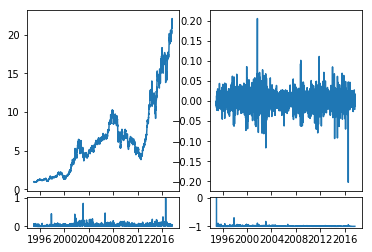

In [11]:
sdp.stock_plot(data_n)

# Transform Data

In [12]:
# training data
prediction_time = 30 #day
testdatasize = 450
unroll_length = 90
testdatacut = testdatasize + unroll_length  + 1

x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ]['Normalised Close'].as_matrix()

# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ]['Normalised Close'].as_matrix()



In [13]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (5140, 16)
y_train (5140,)
x_test (511, 16)
y_test (511,)


# Convert to time series

In [14]:
x_train = sdp.unroll(x_train,unroll_length)
x_test  = sdp.unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]


print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (5050, 90, 16)
y_train (5050,)
x_test (421, 90, 16)
y_test (421,)


# Model Building

In [12]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import lstm, time #helper libraries

Using TensorFlow backend.


In [13]:
x_train.shape

(5050, 90, 16)

In [14]:
model = lstm.build_model([1, 50, 100, 1])

/Users/ahendel1/Documents/Academics/4cast/lstm.py:66: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(50, 1), return_sequences=True, units=50)`
  return_sequences=True))


Compilation Time :  0.012272119522094727


/Users/ahendel1/Documents/Academics/4cast/lstm.py:75: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  output_dim=layers[3]))


In [19]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_shape=(None, x_train.shape[-1]),
    units =50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.01110386848449707


In [16]:
##### Step 3 Train the model
model.fit(
    x_train,
    y_train,
    #batch_size=3028,
    epochs=3,
    validation_split=0.3)

ValueError: Error when checking input: expected lstm_2_input to have shape (None, None, 1) but got array with shape (5050, 90, 16)

In [19]:
model.save('lstm_astc.h5')

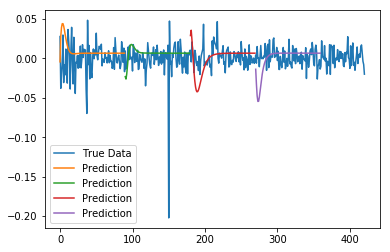

In [23]:
#Step 4 - Plot the predictions!
predictions = lstm.predict_sequences_multiple(model, x_test, 90, 90)
lstm.plot_results_multiple(predictions, y_test, 90)

In [14]:
predictions = lstm.predict_point_by_point(model, x_test)
lstm.plot_results_multiple(predictions, y_test, 50)

NameError: name 'lstm' is not defined